In [1]:
import sys
from pathlib import Path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
import joblib
import warnings
warnings.filterwarnings('ignore')

from config import config

In [2]:
# Load individual model results
print("Loading individual model results...")

try:
    structured_results = joblib.load("../models/structured_results.pkl")
    print("Structured model results loaded")
except:
    print("Structured results not found")
    structured_results = None

try:
    text_results = joblib.load("../models/text_results.pkl")
    print("Text model results loaded")
except:
    print("Text results not found") 
    text_results = None

try:
    image_results = joblib.load("../models/image_results.pkl")
    print("Image model results loaded")
except:
    print("Image results not found")
    image_results = None


Loading individual model results...
Structured model results loaded
Text model results loaded
Image model results loaded


In [3]:
# Load actual labels for evaluation
structured_data = np.load("../models/structured_features.npz")
y_train = structured_data['y_train']
y_test = structured_data['y_test']

print(f"\nDataset info:")
print(f"   Training samples: {len(y_train)}")
print(f"   Test samples: {len(y_test)}")
print(f"   Positive rate: {y_test.mean():.3f}")


Dataset info:
   Training samples: 6677
   Test samples: 1563
   Positive rate: 0.203


In [4]:
# Collect all available predictions for ensemble
ensemble_features_train = []
ensemble_features_test = []
feature_names = []

if structured_results:
    print(f"\nSTRUCTURED MODEL:")
    print(f"   F1: {structured_results['metrics']['f1']:.4f}")
    print(f"   Precision: {structured_results['metrics']['precision']:.4f}")
    
    ensemble_features_train.append(structured_results['train_predictions'])
    ensemble_features_test.append(structured_results['test_predictions'])
    feature_names.append('structured_proba')

if text_results:
    print(f"\nTEXT MODEL:")
    print(f"   F1: {text_results['metrics']['f1']:.4f}")
    print(f"   Precision: {text_results['metrics']['precision']:.4f}")
    
    ensemble_features_train.append(text_results['train_similarities'])
    ensemble_features_test.append(text_results['test_similarities'])
    feature_names.append('text_similarity')

if image_results:
    print(f"\nIMAGE MODEL:")
    print(f"   F1: {image_results['metrics']['f1']:.4f}")
    print(f"   Precision: {image_results['metrics']['precision']:.4f}")
    
    ensemble_features_train.append(image_results['train_similarities'])
    ensemble_features_test.append(image_results['test_similarities'])
    feature_names.append('image_similarity')

print(f"\nENSEMBLE FEATURES:")
print(f"   Available modalities: {len(ensemble_features_train)}")
print(f"   Feature names: {feature_names}")

if len(ensemble_features_train) == 0:
    print("No model results found! Please run individual model training first.")
    exit()


STRUCTURED MODEL:
   F1: 0.9723
   Precision: 0.9518

TEXT MODEL:
   F1: 0.8788
   Precision: 0.9457

IMAGE MODEL:
   F1: 0.8448
   Precision: 0.9915

ENSEMBLE FEATURES:
   Available modalities: 3
   Feature names: ['structured_proba', 'text_similarity', 'image_similarity']


In [5]:
# Create ensemble feature matrix
X_ensemble_train = np.column_stack(ensemble_features_train)
X_ensemble_test = np.column_stack(ensemble_features_test)

print(f"   Ensemble training shape: {X_ensemble_train.shape}")
print(f"   Ensemble test shape: {X_ensemble_test.shape}")

# Simple weighted average ensemble (baseline)
def weighted_ensemble(predictions, weights=None):
    """Simple weighted average of predictions"""
    if weights is None:
        weights = np.ones(len(predictions)) / len(predictions)
    
    ensemble_pred = np.zeros_like(predictions[0])
    for i, pred in enumerate(predictions):
        ensemble_pred += weights[i] * pred
    return ensemble_pred



   Ensemble training shape: (6677, 3)
   Ensemble test shape: (1563, 3)


In [6]:
# Try different weight combinations
weight_combinations = [
    [1.0],  # Only structured (if available)
    [0.5, 0.5],  # Equal weights (if 2 models)
    [0.6, 0.4],  # Favor first model
    [0.7, 0.3],  # Strong favor first model
    [0.33, 0.33, 0.34],  # Equal three models
    [0.5, 0.3, 0.2],  # Structured > Text > Image
    [0.6, 0.25, 0.15],  # Strong structured preference
]

print(f"\n TESTING ENSEMBLE COMBINATIONS:")
best_f1 = 0
best_weights = None
best_predictions = None
weight_results = []

for weights in weight_combinations:
    if len(weights) != len(ensemble_features_test):
        continue
    
    # Create ensemble predictions
    ensemble_pred_proba = weighted_ensemble(ensemble_features_test, weights)
    
    # Find optimal threshold
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (ensemble_pred_proba >= threshold).astype(int)
        if len(np.unique(y_pred)) > 1:
            f1 = f1_score(y_test, y_pred)
            if f1 > best_threshold_f1:
                best_threshold_f1 = f1
                best_threshold = threshold
    
    # Evaluate with best threshold
    y_pred_final = (ensemble_pred_proba >= best_threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_final)
    precision = precision_score(y_test, y_pred_final)
    recall = recall_score(y_test, y_pred_final)
    f1 = f1_score(y_test, y_pred_final)
    
    weight_results.append({
        'weights': weights,
        'threshold': best_threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions_proba': ensemble_pred_proba
    })
    
    meets_precision = precision >= 0.85
    meets_f1 = f1 >= 0.80
    
    print(f"   Weights {weights}: F1={f1:.4f}, Prec={precision:.4f} {'Good' if meets_precision and meets_f1 else 'Not good'}")
    
    # Track best performing combination
    if f1 > best_f1:
        best_f1 = f1
        best_weights = weights
        best_predictions = ensemble_pred_proba
        best_threshold_global = best_threshold

print(f"\nBEST ENSEMBLE COMBINATION:")
print(f"   Weights: {best_weights}")
print(f"   Threshold: {best_threshold_global:.3f}")
print(f"   F1 Score: {best_f1:.4f}")



 TESTING ENSEMBLE COMBINATIONS:
   Weights [0.33, 0.33, 0.34]: F1=0.8592, Prec=0.9918 Good
   Weights [0.5, 0.3, 0.2]: F1=0.9246, Prec=0.9658 Good
   Weights [0.6, 0.25, 0.15]: F1=0.9442, Prec=0.9579 Good

BEST ENSEMBLE COMBINATION:
   Weights: [0.6, 0.25, 0.15]
   Threshold: 0.400
   F1 Score: 0.9442


In [7]:
# Get best result details
best_result = next(r for r in weight_results if r['f1'] == best_f1)
print(f"   Accuracy: {best_result['accuracy']:.4f}")
print(f"   Precision: {best_result['precision']:.4f} {'Good' if best_result['precision'] >= 0.85 else 'Not good'}")
print(f"   Recall: {best_result['recall']:.4f}")
print(f"   F1-Score: {best_result['f1']:.4f} {'Good' if best_result['f1'] >= 0.80 else 'Not good'}")

   Accuracy: 0.9776
   Precision: 0.9579 Good
   Recall: 0.9308
   F1-Score: 0.9442 Good


In [8]:
# Advanced ensemble: Train meta-classifier
print(f"\n🤖 TRAINING META-CLASSIFIER:")

meta_classifiers = {
    'LogisticRegression': LogisticRegression(random_state=config.random_state, max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=config.random_state),
    'XGBoost': xgb.XGBClassifier(random_state=config.random_state, eval_metric='logloss')
}

best_meta_model = None
best_meta_f1 = 0
meta_results = {}

for name, model in meta_classifiers.items():
    try:
        # Train meta-classifier
        model.fit(X_ensemble_train, y_train)
        
        # Predict on test set
        y_pred_proba = model.predict_proba(X_ensemble_test)[:, 1]
        
        # Optimize threshold
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_threshold_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            if len(np.unique(y_pred)) > 1:
                f1 = f1_score(y_test, y_pred)
                if f1 > best_threshold_f1:
                    best_threshold_f1 = f1
                    best_threshold = threshold
        
        # Final evaluation
        y_pred_final = (y_pred_proba >= best_threshold).astype(int)
        
        accuracy = accuracy_score(y_test, y_pred_final)
        precision = precision_score(y_test, y_pred_final)
        recall = recall_score(y_test, y_pred_final)
        f1 = f1_score(y_test, y_pred_final)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        meta_results[name] = {
            'model': model,
            'threshold': best_threshold,
            'predictions_proba': y_pred_proba,
            'predictions': y_pred_final,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
        
        meets_targets = precision >= 0.85 and f1 >= 0.80
        print(f"   {name}: F1={f1:.4f}, Prec={precision:.4f} {'Good' if meets_targets else 'Not good'}")
        
        if f1 > best_meta_f1:
            best_meta_f1 = f1
            best_meta_model = model
            
    except Exception as e:
        print(f"   {name}: Failed - {str(e)}")



🤖 TRAINING META-CLASSIFIER:
   LogisticRegression: F1=0.9768, Prec=0.9605 Good
   RandomForest: F1=0.9798, Prec=0.9664 Good
   XGBoost: F1=0.9752, Prec=0.9632 Good


In [9]:
# Individual models
if structured_results:
    s_meets = structured_results['metrics']['precision'] >= 0.85 and structured_results['metrics']['f1'] >= 0.80
    print(f"{'Structured Only':<20} {structured_results['metrics']['f1']:<8.4f} {structured_results['metrics']['precision']:<10.4f} {structured_results['metrics']['recall']:<8.4f} {'Good' if s_meets else 'Not good'}")

if text_results:
    t_meets = text_results['metrics']['precision'] >= 0.85 and text_results['metrics']['f1'] >= 0.80
    print(f"{'Text Only':<20} {text_results['metrics']['f1']:<8.4f} {text_results['metrics']['precision']:<10.4f} {text_results['metrics']['recall']:<8.4f} {'Good' if t_meets else 'Not good'}")

if image_results:
    i_meets = image_results['metrics']['precision'] >= 0.85 and image_results['metrics']['f1'] >= 0.80
    print(f"{'Image Only':<20} {image_results['metrics']['f1']:<8.4f} {image_results['metrics']['precision']:<10.4f} {image_results['metrics']['recall']:<8.4f} {'Good' if i_meets else 'Not good'}")

Structured Only      0.9723   0.9518     0.9937   Good
Text Only            0.8788   0.9457     0.8208   Good
Image Only           0.8448   0.9915     0.7358   Good


In [10]:
# Ensemble approaches
ensemble_meets = best_result['precision'] >= 0.85 and best_result['f1'] >= 0.80
print(f"{'Weighted Ensemble':<20} {best_result['f1']:<8.4f} {best_result['precision']:<10.4f} {best_result['recall']:<8.4f} {'Good' if ensemble_meets else 'Not good'}")

# Meta-classifiers
for name, result in meta_results.items():
    meta_meets = result['precision'] >= 0.85 and result['f1'] >= 0.80
    print(f"{f'Meta-{name}':<20} {result['f1']:<8.4f} {result['precision']:<10.4f} {result['recall']:<8.4f} {'Good' if meta_meets else 'Not good'}")

# Select best overall approach
all_approaches = [
    ('Weighted Ensemble', best_result),
    *[(f'Meta-{name}', result) for name, result in meta_results.items()]
]

Weighted Ensemble    0.9442   0.9579     0.9308   Good
Meta-LogisticRegression 0.9768   0.9605     0.9937   Good
Meta-RandomForest    0.9798   0.9664     0.9937   Good
Meta-XGBoost         0.9752   0.9632     0.9874   Good


In [11]:
# Prioritize approaches that meet precision target, then F1
qualified_approaches = [(name, result) for name, result in all_approaches 
                       if result['precision'] >= 0.85]

if qualified_approaches:
    final_name, final_result = max(qualified_approaches, key=lambda x: x[1]['f1'])
    print(f"\n SELECTED APPROACH: {final_name}")
else:
    final_name, final_result = max(all_approaches, key=lambda x: x[1]['f1'])
    print(f"\n BEST AVAILABLE: {final_name} (precision target not met)")

print(f"   Final F1: {final_result['f1']:.4f}")
print(f"   Final Precision: {final_result['precision']:.4f}")
print(f"   Final Recall: {final_result['recall']:.4f}")


 SELECTED APPROACH: Meta-RandomForest
   Final F1: 0.9798
   Final Precision: 0.9664
   Final Recall: 0.9937


In [12]:
# Save final ensemble model
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

if 'Meta-' in final_name:
    # Save meta-classifier
    model_name = final_name.replace('Meta-', '').lower()
    final_model = meta_results[final_name.replace('Meta-', '')]['model']
    
    ensemble_model_data = {
        'approach': 'meta_classifier',
        'model': final_model,
        'threshold': final_result['threshold'],
        'feature_names': feature_names,
        'weights': None,
        'performance': {
            'accuracy': final_result['accuracy'],
            'precision': final_result['precision'],
            'recall': final_result['recall'],
            'f1': final_result['f1'],
            'auc': final_result.get('auc', 0.0)
        },
        'train_features': X_ensemble_train,
        'test_predictions': final_result['predictions_proba']
    }
    
    print(f"   Approach: Meta-classifier ({model_name})")
    
else:
    # Save weighted ensemble
    ensemble_model_data = {
        'approach': 'weighted_ensemble',
        'model': None,  # No trained model, just weights
        'threshold': final_result['threshold'],
        'feature_names': feature_names,
        'weights': best_weights,
        'performance': final_result,
        'train_features': X_ensemble_train,
        'test_predictions': final_result['predictions_proba']
    }
    
    print(f"   Approach: Weighted ensemble {best_weights}")

# Save the ensemble model
joblib.dump(ensemble_model_data, models_dir / "ensemble_model.pkl")

   Approach: Meta-classifier (randomforest)


['../models/ensemble_model.pkl']

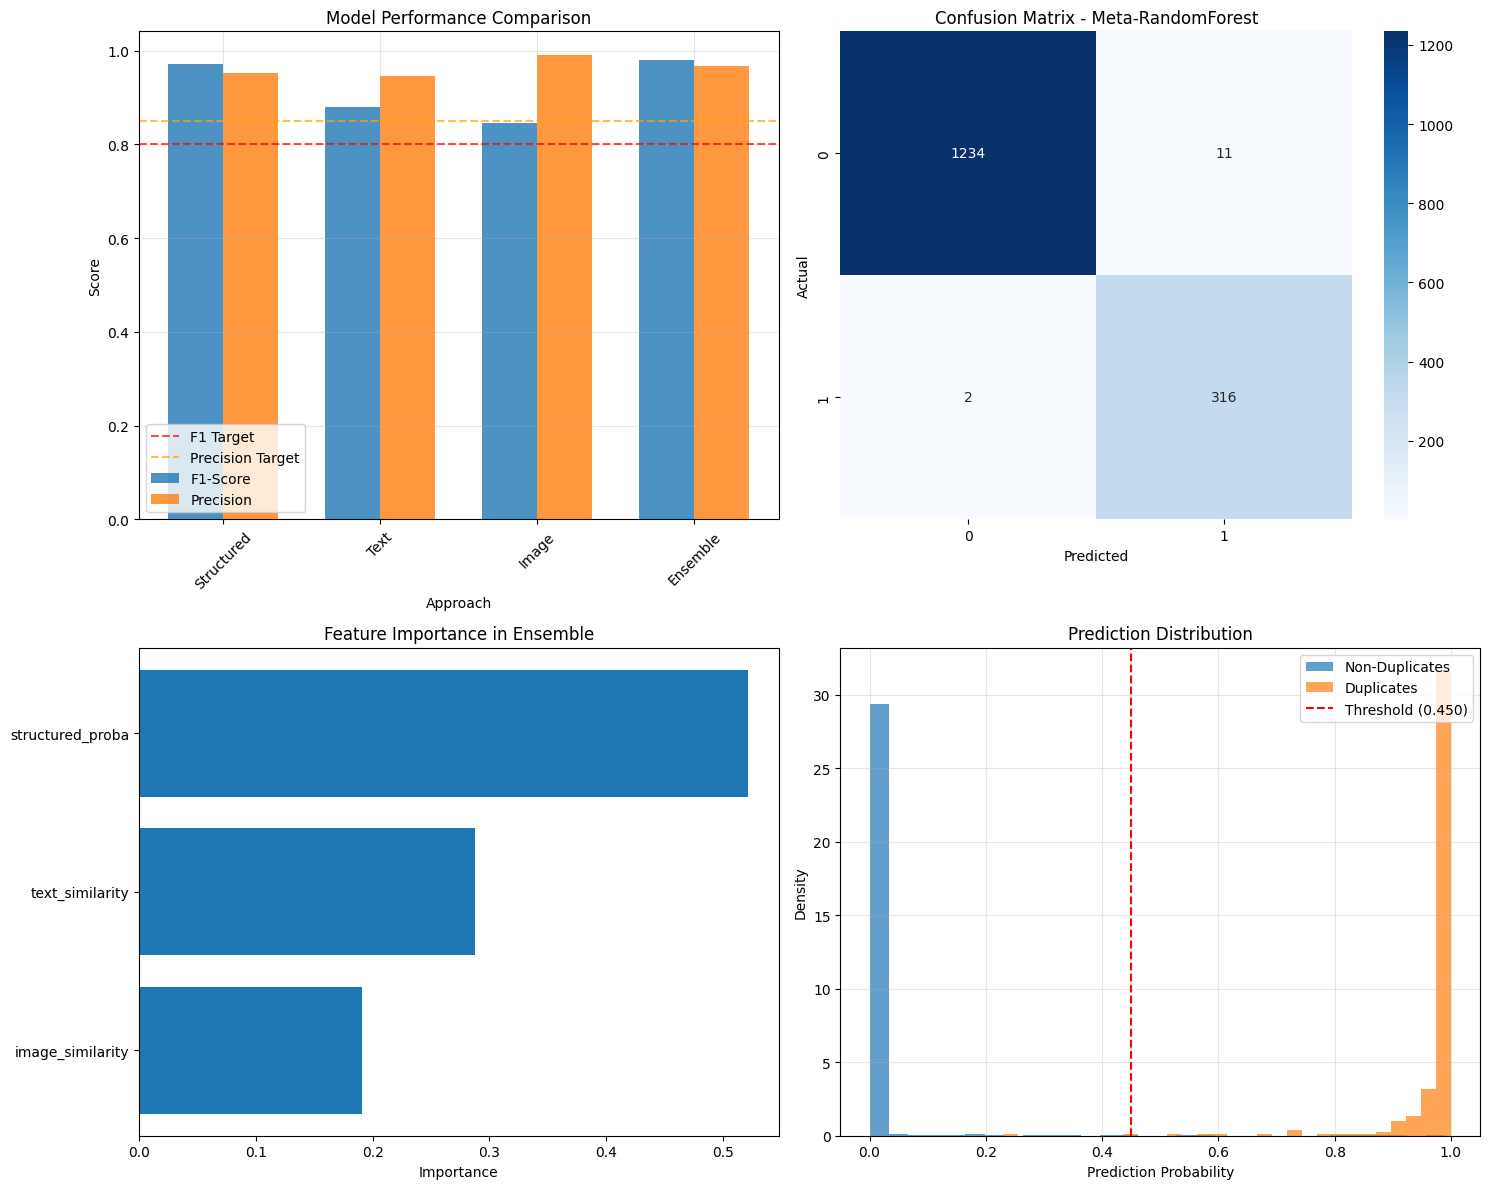

In [13]:
# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Performance comparison
approaches = ['Structured', 'Text', 'Image', 'Ensemble']
f1_scores = []
precisions = []

if structured_results:
    f1_scores.append(structured_results['metrics']['f1'])
    precisions.append(structured_results['metrics']['precision'])
else:
    f1_scores.append(0)
    precisions.append(0)

if text_results:
    f1_scores.append(text_results['metrics']['f1'])
    precisions.append(text_results['metrics']['precision'])
else:
    f1_scores.append(0)
    precisions.append(0)
    
if image_results:
    f1_scores.append(image_results['metrics']['f1'])
    precisions.append(image_results['metrics']['precision'])
else:
    f1_scores.append(0)
    precisions.append(0)

f1_scores.append(final_result['f1'])
precisions.append(final_result['precision'])

x_pos = np.arange(len(approaches))
width = 0.35

ax1.bar(x_pos - width/2, f1_scores, width, label='F1-Score', alpha=0.8)
ax1.bar(x_pos + width/2, precisions, width, label='Precision', alpha=0.8)
ax1.axhline(y=0.80, color='r', linestyle='--', alpha=0.7, label='F1 Target')
ax1.axhline(y=0.85, color='orange', linestyle='--', alpha=0.7, label='Precision Target')
ax1.set_xlabel('Approach')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(approaches, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Confusion matrix for final model
y_pred_final = (final_result['predictions_proba'] >= final_result['threshold']).astype(int)
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', ax=ax2, cmap='Blues')
ax2.set_title(f'Confusion Matrix - {final_name}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# Feature importance (if meta-classifier)
if 'model' in final_result and final_result.get('model') and hasattr(final_result['model'], 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': final_result['model'].feature_importances_
    }).sort_values('Importance', ascending=True)
    
    ax3.barh(importance_df['Feature'], importance_df['Importance'])
    ax3.set_title('Feature Importance in Ensemble')
    ax3.set_xlabel('Importance')
elif best_weights:
    # Show weights for weighted ensemble
    weights_df = pd.DataFrame({
        'Feature': feature_names,
        'Weight': best_weights
    }).sort_values('Weight', ascending=True)
    
    ax3.barh(weights_df['Feature'], weights_df['Weight'])
    ax3.set_title('Feature Weights in Ensemble')
    ax3.set_xlabel('Weight')

# ROC curve or prediction distribution
prediction_probs = final_result['predictions_proba']
ax4.hist(prediction_probs[y_test == 0], bins=30, alpha=0.7, label='Non-Duplicates', density=True)
ax4.hist(prediction_probs[y_test == 1], bins=30, alpha=0.7, label='Duplicates', density=True)
ax4.axvline(x=final_result['threshold'], color='red', linestyle='--', label=f'Threshold ({final_result["threshold"]:.3f})')
ax4.set_xlabel('Prediction Probability')
ax4.set_ylabel('Density')
ax4.set_title('Prediction Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/ensemble_model_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
print(f"\n ENSEMBLE MODEL SAVED:")
print(f"   Model file: ../models/ensemble_model.pkl")
print(f"   Visualization: ../data/processed/ensemble_model_results.png")
print(f"   Ready for production API!")

# Quick test of saved model
print(f"\n TESTING SAVED MODEL:")
loaded_ensemble = joblib.load("../models/ensemble_model.pkl")
print(f"   Approach: {loaded_ensemble['approach']}")
print(f"   Features: {loaded_ensemble['feature_names']}")
print(f"   Threshold: {loaded_ensemble['threshold']}")
print(f"   Performance: F1={loaded_ensemble['performance']['f1']:.4f}, Precision={loaded_ensemble['performance']['precision']:.4f}")



 ENSEMBLE MODEL SAVED:
   Model file: ../models/ensemble_model.pkl
   Visualization: ../data/processed/ensemble_model_results.png
   Ready for production API!

 TESTING SAVED MODEL:
   Approach: meta_classifier
   Features: ['structured_proba', 'text_similarity', 'image_similarity']
   Threshold: 0.45000000000000007
   Performance: F1=0.9798, Precision=0.9664
